#KaKR과 함께하는 2019 두 번째 ML 달
##캐글 코리아와 함께하는 2nd ML 대회-주택 가격 예측
data set = https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

* 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
* 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
* 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
* 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
* Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install missingno

## IMPORT MODULE

In [3]:
import os, zipfile

dst_path='/content/kaggle-kakr-housing-data.zip'
dst='/content/kaggle/'

if not os.path.exists(dst):
    os.makedirs(dst)

with zipfile.ZipFile(dst_path,mode='r') as file:
    file.extractall(dst)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
train_data_path = '/content/kaggle/data/train.csv'
test_data_path = '/content/kaggle/data/test.csv'

data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


# DATASET EDA$&PREPROCESSING

In [93]:
'''
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
'''
data.head(5)
data.shape

(15035, 21)

In [94]:
y = data['price']
data = data.drop('price',axis=1,inplace=False)

In [95]:
train_len = len(data)
print(train_len)

print(len(test))
data = pd.concat((data, test), axis=0)
print(len(data))

15035
6468
21503


In [96]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


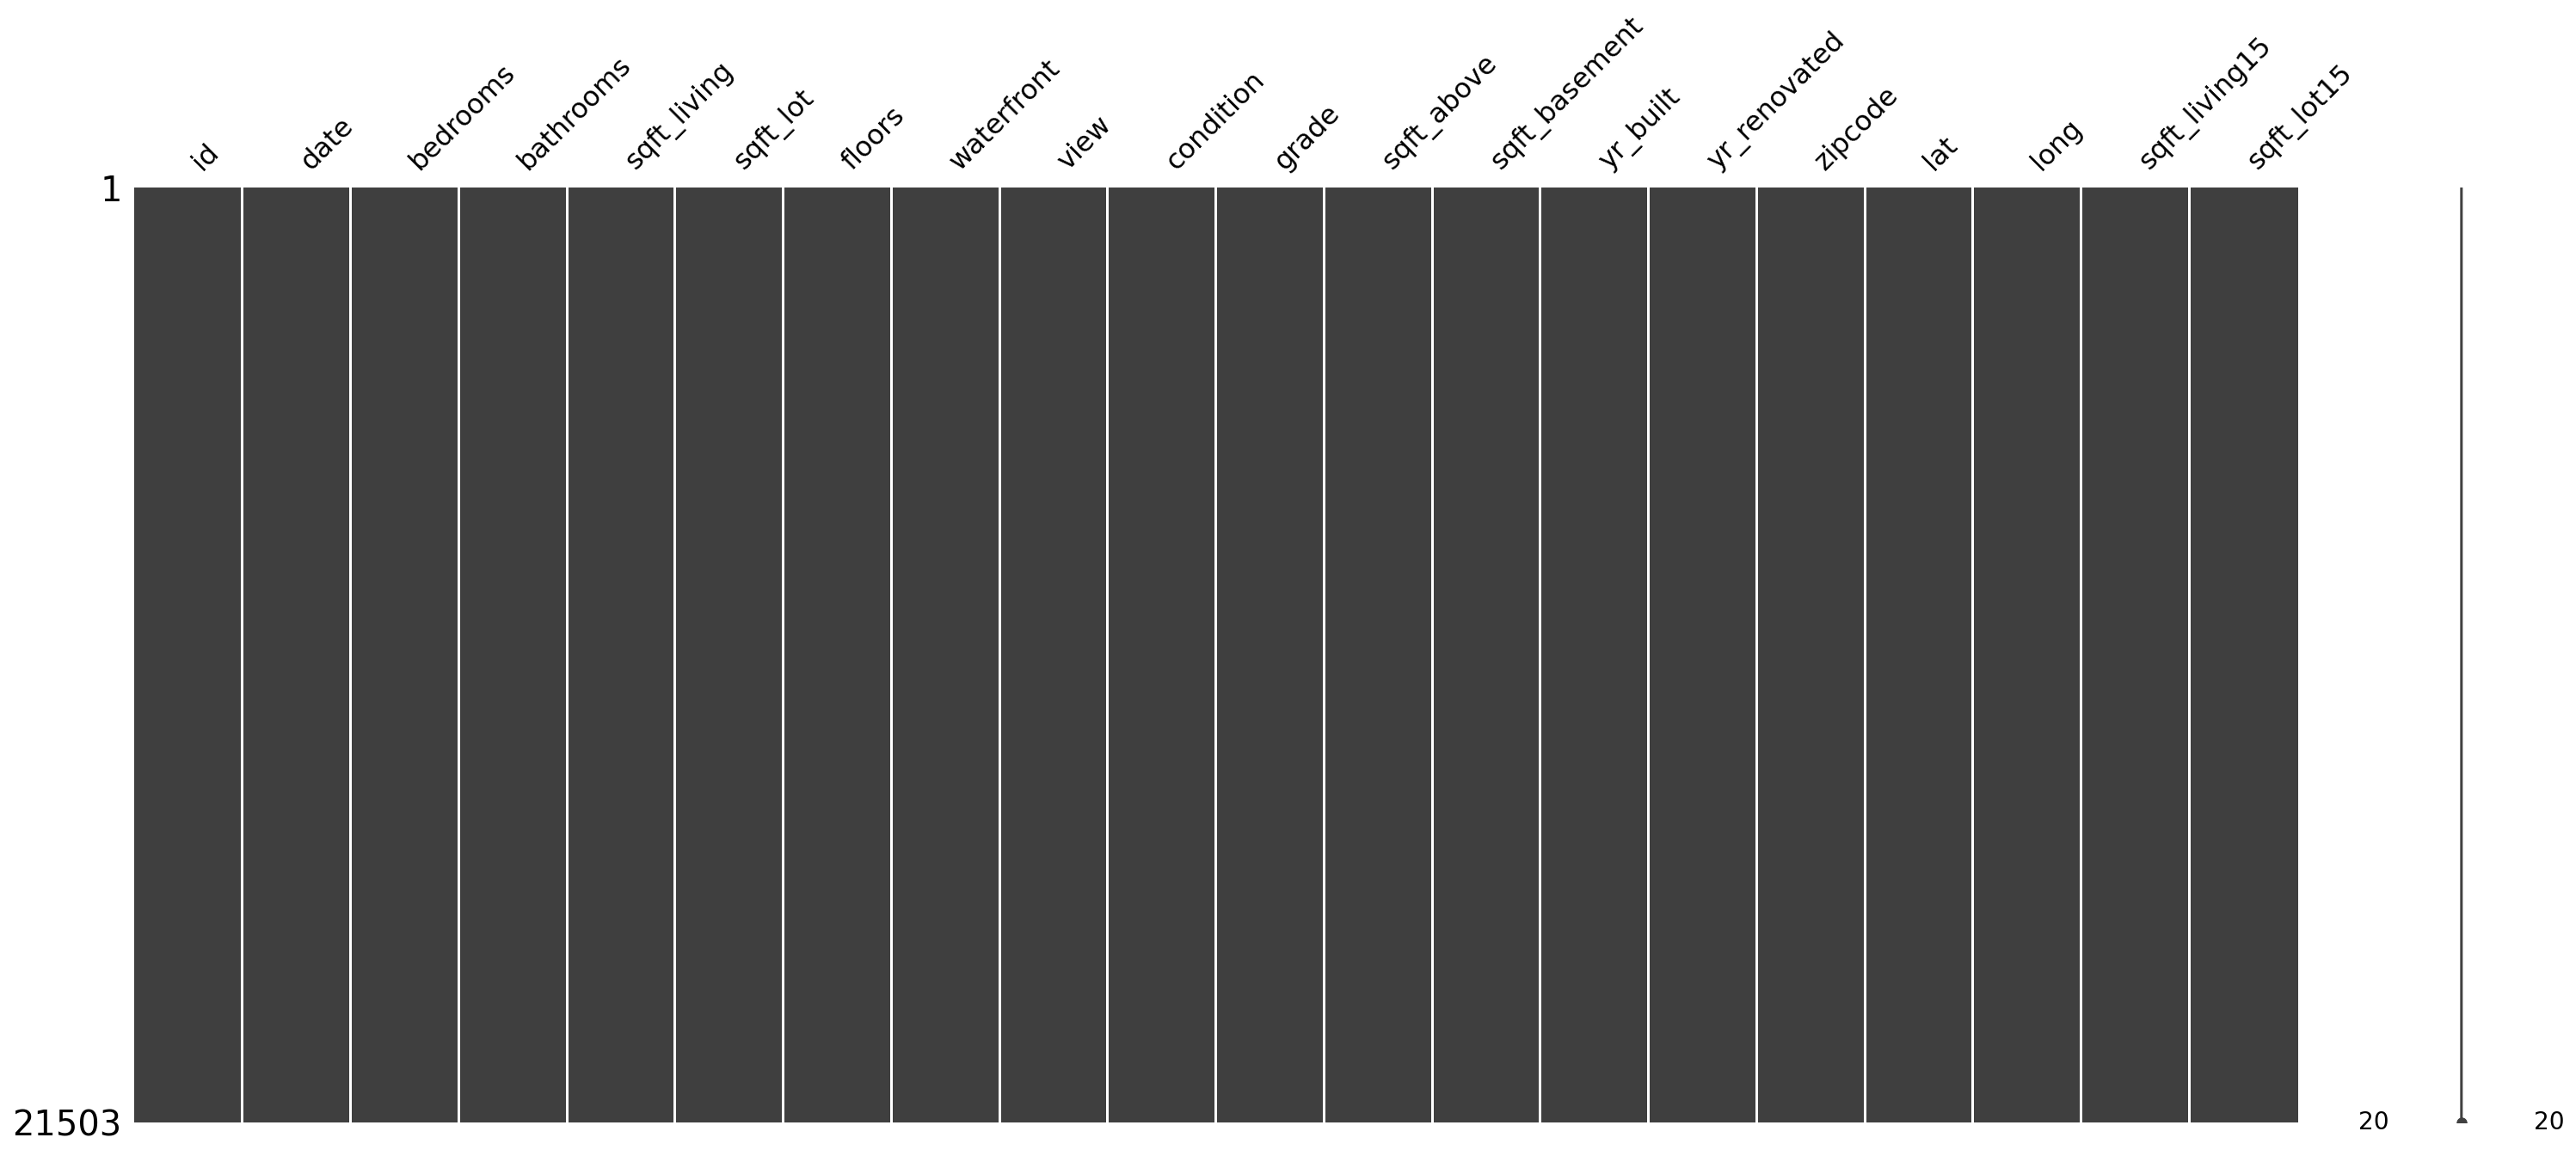

In [97]:
'''
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
먼저 데이터에 결측치가 있는지를 확인하겠습니다.
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.
'''
msno.matrix(data)

In [98]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [99]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [100]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


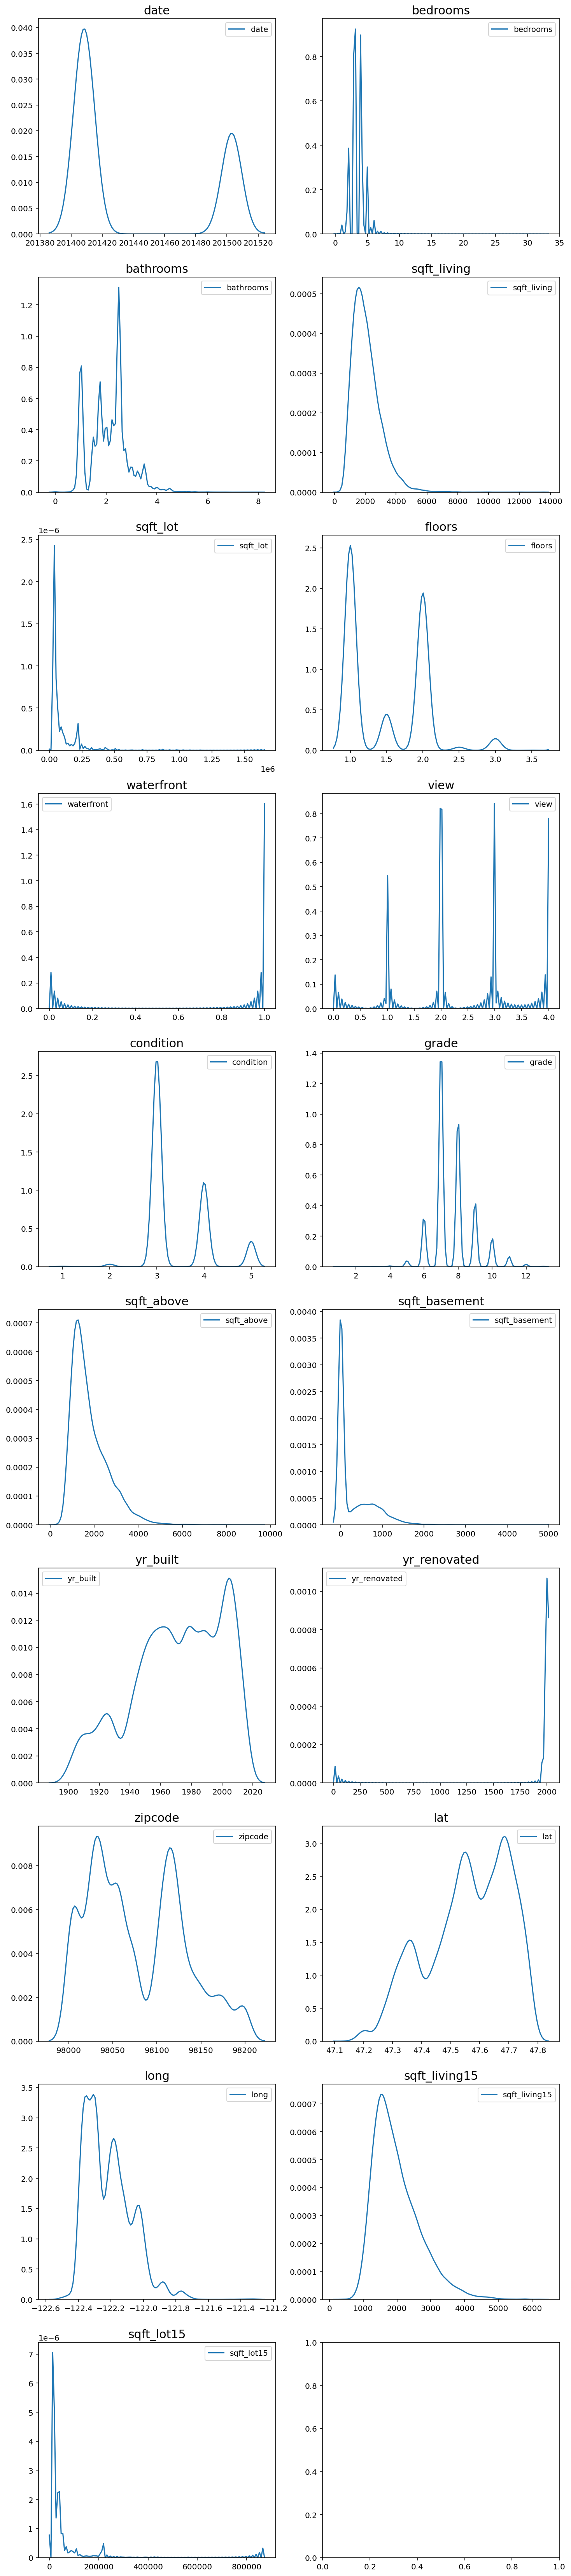

In [101]:
fig, ax = plt.subplots(10, 2, figsize=(12, 60))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [102]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

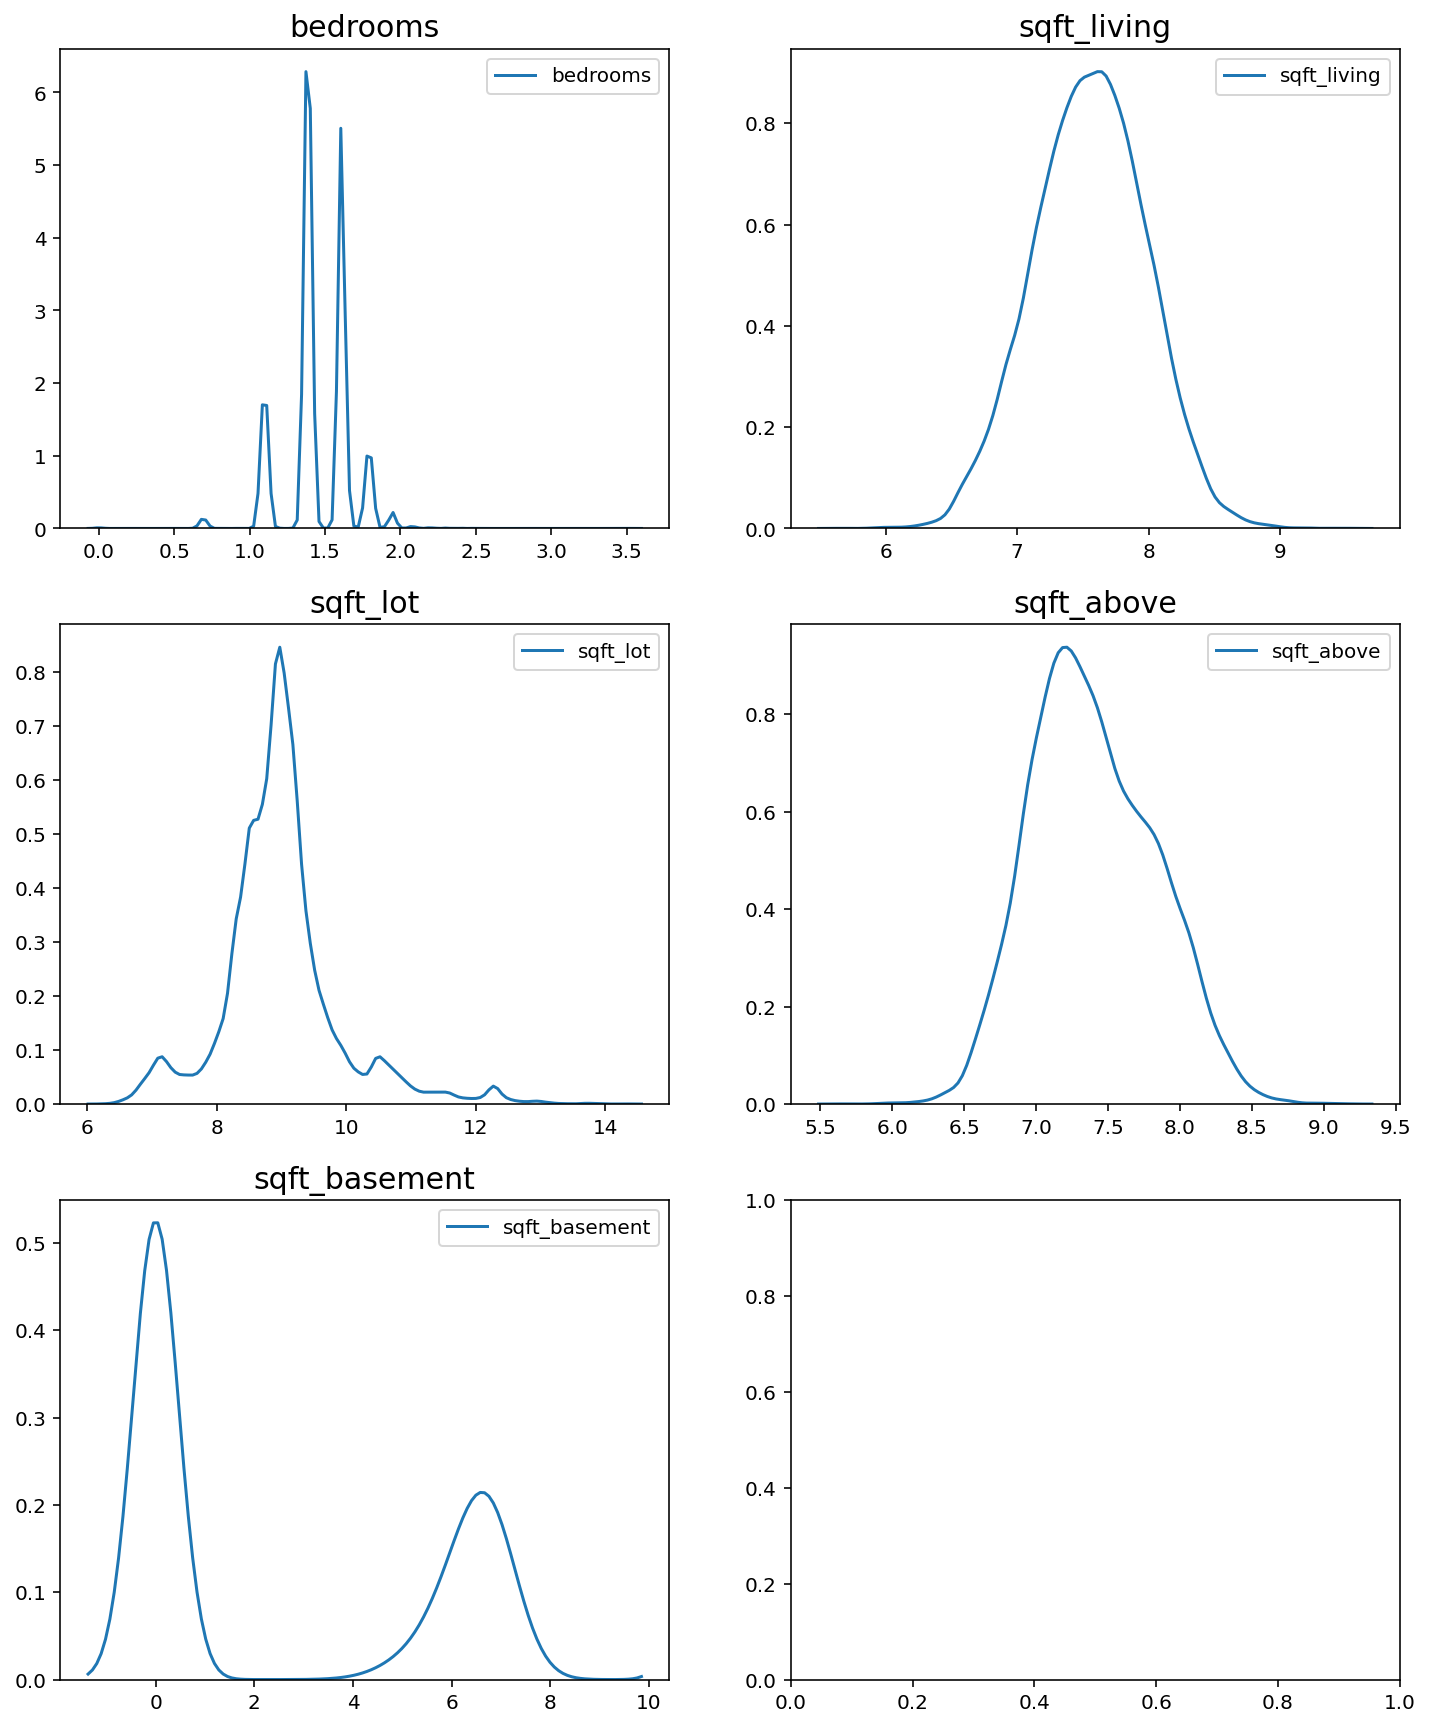

In [103]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

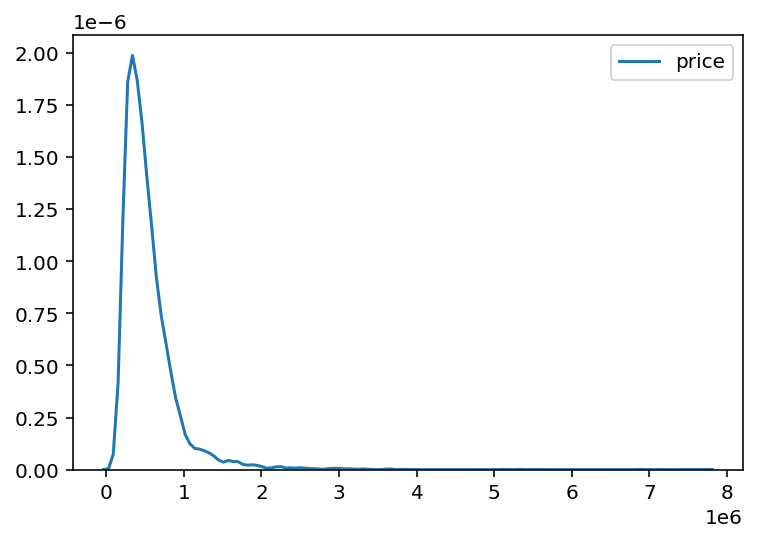

In [104]:
sns.kdeplot(y)
plt.show()

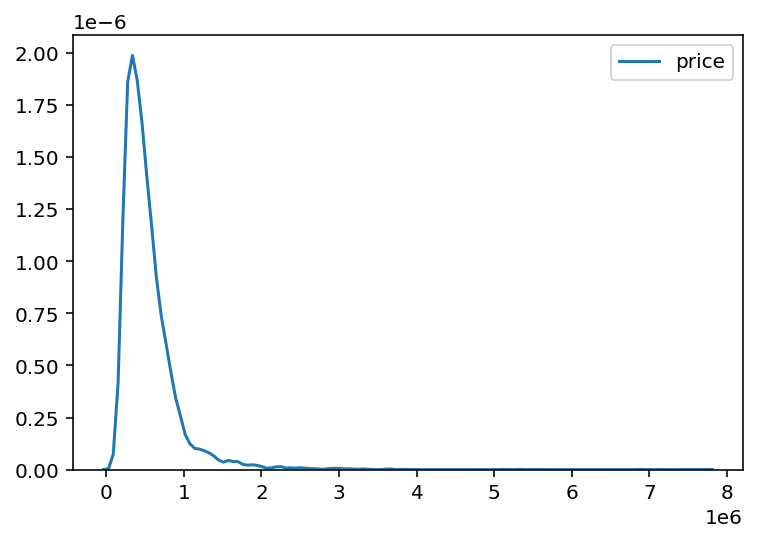

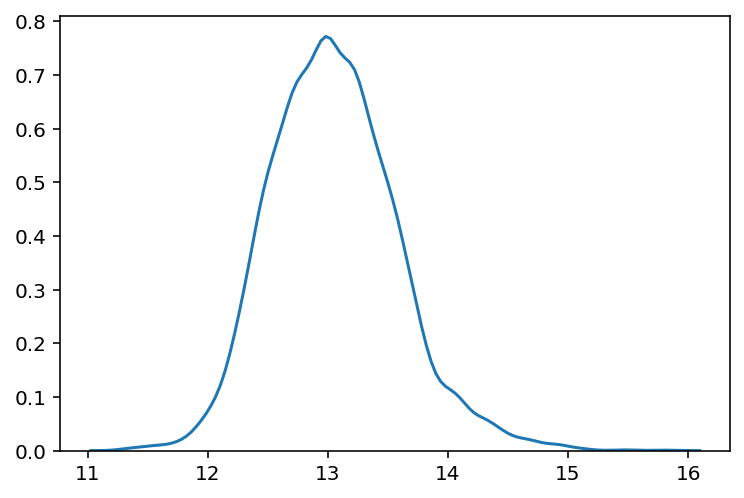

In [105]:
skew_columns = ['price']
sns.kdeplot(y)
plt.show()
for c in skew_columns:
    log_y = np.log1p(y.values)
sns.kdeplot(log_y)
plt.show()

In [106]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)
print(y.shape)

(15035, 19)
(6468, 19)
(15035,)


# MODELING
이제 본격적으로 학습시킬 모델을 준비합니다. Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.

https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.


---

앙상블(Ensemble) 학습은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법입니다.

하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작되었습니다.


* 1-1) Voting은 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용됩니다 & Averaging은 각 모델이 계산해 낸 실수값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용됩니다. majority voting / weighted voting / simple averaging / weighted averaging 

* Bagging = Bootstrap Aggregating 평균을 통해 분산값을 줄여 모델을 일반화 
>  bagging meta-estimator 일정 수의 base model 생성, 알고리즘 동일, 각 다른 서브 데이터셋  / random forest 특성을 랜덤으로 하여 진행, 튜닝시간이 오래걸림 = 하이퍼파라미터가 너무 많음 

* boosting : 여러 개의 약한 학습기를 순차적으로 학습-예측하며 잘못 예측한 데이터에 가중치 부여를 진행하며 오류를 개선해나감 
> AdaBoost : Adaptive boosting의 약자로 오류 데이터에 가중치를 부여하며 부스팅을 수행하는 대표적인 알고리즘, 이상치에 민감  / Gradient Boost : 가중치 업데이트를 경사하강법(Gradient Descent) 로 한다는 점 / XGBoost : XGBoost(eXtra Gradient Boost) 는 GBM에 기반하는 알고리즘이며, 여러 가지 장점을 가진 알고리즘 / LightGBM : XGBoost에 비해 훨씬 빠르며, 메모리 사용량도 상대적으로 적습니다. 예측 성능 자체도 큰 차이는 없습니다. 하지만 적은 수의 데이터셋에는 과대적합이 발생하기 쉽다는 단점

In [107]:
random_state=191970
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [108]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [109]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=random_state).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [110]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8590
[01:15:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:15:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBoost CV score : 0.8624
Model LightGBM CV score : 0.8819


In [111]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [112]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

[01:16:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([ 562566.39221578,  389660.68147617, 1340643.45409443, ...,
        438058.69137012,  345498.01852609,  414241.23776683])

# TUNING

In [113]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [115]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [116]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [117]:
random_state=191970        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [118]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [119]:
from sklearn.model_selection import GridSearchCV
'''
param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
scoring : 모델의 성능을 평가할 지표
cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
n_jobs : 그리드 탐색을 진행하면서 몇 개를 병행할 것인가
'''
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [120]:
model = LGBMRegressor(random_state=random_state)

In [121]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    7.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=191970,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean

In [123]:
grid_model.cv_results_

{'mean_fit_time': array([0.31053061, 0.38783298, 0.9925559 , 1.64332495]),
 'mean_score_time': array([0.02952833, 0.04279585, 0.05787964, 0.06327806]),
 'mean_test_score': array([-0.07339763, -0.05502319, -0.02917323, -0.02702383]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885212, -0.02664695]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041411, -0.02795762]),
 'split2_test_score': array([-0.07354904, -0.05546079, 

In [124]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [125]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339763, -0.05502319, -0.02917323, -0.02702383])

In [126]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073398
1,1,100,-0.055023
2,10,50,-0.029173
3,10,100,-0.027024


In [127]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073398,0.270920
1,1,100,-0.055023,0.234570
2,10,50,-0.029173,0.170802
3,10,100,-0.027024,0.164389


In [128]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073398,0.270920
1,1,100,-0.055023,0.234570
2,10,50,-0.029173,0.170802
3,10,100,-0.027024,0.164389


In [129]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


In [130]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [131]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    3.6s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


In [132]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [133]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [134]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# REAL GRID SEARCH

In [135]:
model = LGBMRegressor(random_state=191970)

param_grid = {
    'n_estimators': [25,50,75,100,125],
    'max_depth': [1 , 12],
    'num_leaves':[30],
    'feature_fraction':[0.3,0.5],  
    'bagging_fraction':[0.5,0.8], 
    'bagging_freq':[15], 
    'learning_rate':[0.01,0.05], 
}

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 215 tasks      | elapsed:   26.1s
[Parallel(n_jobs=5)]: Done 400 out of 400 | elapsed:   52.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=191970,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'bagging_fraction': [0.5, 0.8], 'bagging_freq': [15],
                         'feature_fraction': [0.3, 0.5],
                         'learning_rate': [0.

In [136]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')

results

,bagging_fraction,bagging_freq,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
79,0.8,15,0.5,0.05,12,125,30,-0.027991,0.167304
39,0.5,15,0.5,0.05,12,125,30,-0.028284,0.168179
78,0.8,15,0.5,0.05,12,100,30,-0.029480,0.171698
38,0.5,15,0.5,0.05,12,100,30,-0.029777,0.172561
59,0.8,15,0.3,0.05,12,125,30,-0.030173,0.173703
...,...,...,...,...,...,...,...,...,...
1,0.5,15,0.3,0.01,1,50,30,-0.215657,0.464389
60,0.8,15,0.5,0.01,1,25,30,-0.240418,0.490324
20,0.5,15,0.5,0.01,1,25,30,-0.240467,0.490374
40,0.8,15,0.3,0.01,1,25,30,-0.242826,0.492774


In [86]:
results.columns

Index(['bagging_fraction', 'bagging_freq', 'feature_fraction', 'learning_rate',
       'max_depth', 'n_estimators', 'num_leaves', 'score', 'RMSLE'],
      dtype='object')

In [137]:
model = LGBMRegressor(
    bagging_fraction=0.8,
    bagging_freq=15,
    feature_fraction=0.5,
    learning_rate=0.05,
    num_leaves=30,
    max_depth=12, 
    n_estimators=125, 
    random_state=191970)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.20058353, 13.00804787, 14.08565277, ..., 12.96110304,
       12.64071924, 12.9390432 ])

In [138]:
prediction = np.expm1(prediction)
prediction

array([ 540679.34855869,  445987.24420055, 1310149.75642189, ...,
        425534.24039447,  308882.43187762,  416249.78053747])

In [144]:
def save_submission(model, train, y, test, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/kaggle/data/'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_RMSLE_{}.csv'.format(data_dir, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [146]:
save_submission(model,train,y,test)

/content/kaggle/data//submission_RMSLE_None.csv saved!


이름
제출 됨
대기 시간
실행 시간
점수
submission_RMSLE_None.csv
방금
0 초
0 초
117969.73370